# **OpenFoodFact**

#I. IMPORT


In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import joblib
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
pd.set_option('max_colwidth', 20000)
import re
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, make_scorer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
rawdata = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Data/en.openfoodfacts.org.products.csv', sep='\t')

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/eda.csv")
# data.info()
data = data.drop(columns=["url","Countries"])
data.head(1)

,Name,Ingredients,Category,Label,nutri_score,nutri_grade,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal,additives,Additives_count
0,Cranberries,"Cranberries, sugar, sunflower oil.",Cranberries,Unknown,3.0,c,3.0,0.0,0.0,0.0,66.67,83.33,0.0,0.0,10.0,0.0,300.0,Unknown,0


#II. EDA

##Nutrients vs. Food Quality

In [ ]:
def boxplot_multi_nova(feature):
  """
  Draw a boxplot for a given feature
  """
  sns.boxplot(data=df_nova, x='nova_grade', y=feature)
  plt.ylabel(feature, fontsize=16)
  # plt.ylim(bottom=0)
  plt.xlabel("")

order_nutri = pd.value_counts(df_nutri['nutri_grade']).sort_index().index

def boxplot_multi_nutri(feature):
  """
  Draw a boxplot for a given feature
  """
  sns.boxplot(data=df_nutri, x='nutri_grade', y=feature, order=order_nutri)
  plt.xlabel("")
  plt.ylabel(feature, fontsize=16)

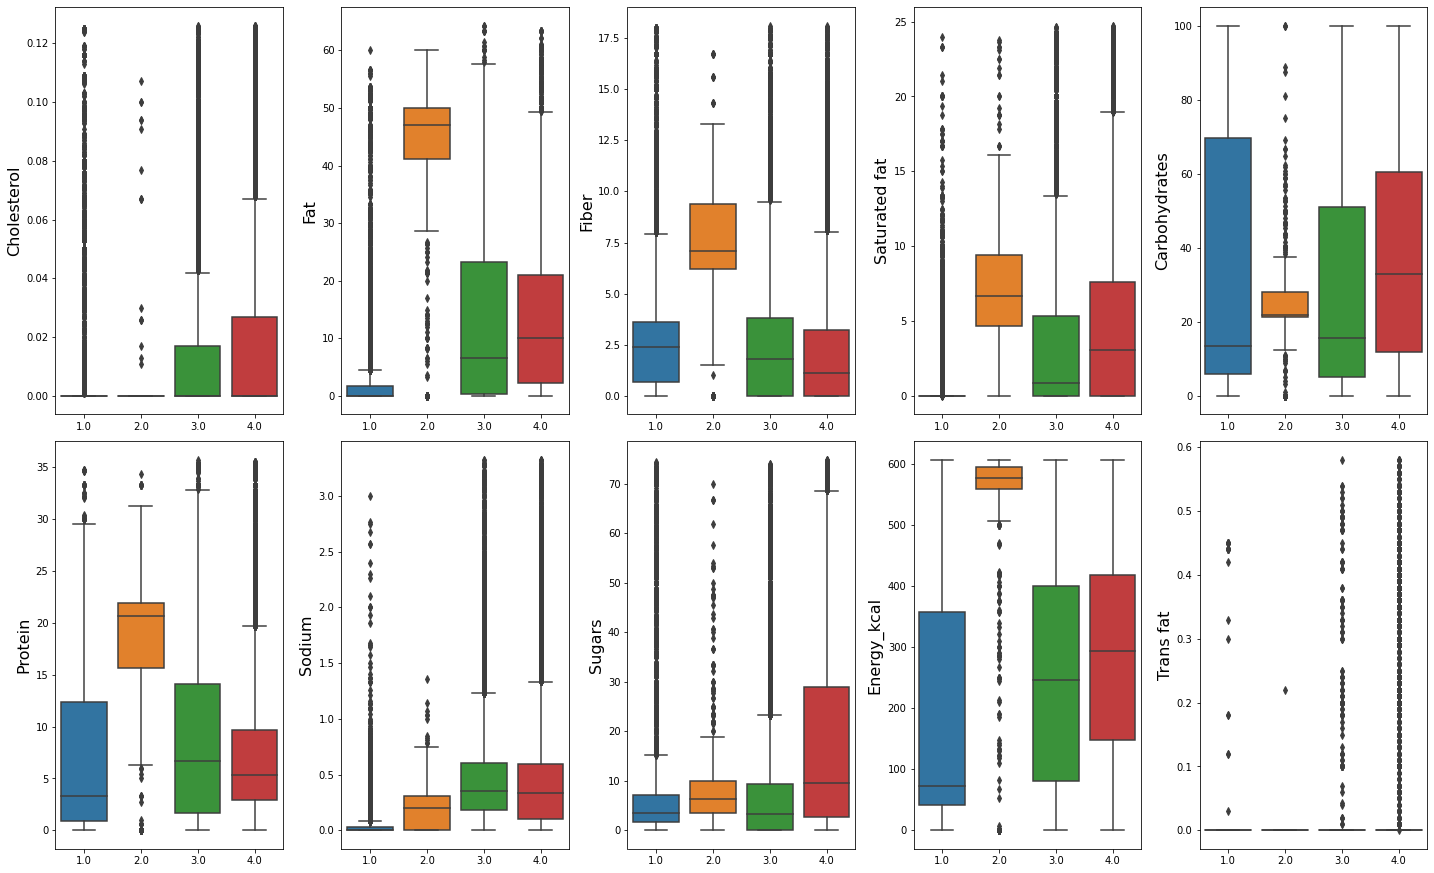

In [ ]:
#Distribution of Nutrient for each Nova-grade

plt.figure(figsize=(20,18))
# plt.title("How do Nutrients distribute for each Nova-grade?")

plt.subplot(351)
boxplot_multi_nova('Cholesterol')
# plt.ylim(top=0.2, bottom=-0.01)
# sns.boxplot(data=df_nova, x='nova_grade', y='Cholesterol', showfliers=False)
# plt.ylabel('Cholesterol', fontsize=16)
# plt.xlabel("")
plt.subplot(352)
boxplot_multi_nova('Fat')
plt.subplot(353)
boxplot_multi_nova('Fiber')
plt.subplot(354)
boxplot_multi_nova('Saturated fat')
plt.subplot(355)
boxplot_multi_nova('Carbohydrates')
plt.subplot(356)
boxplot_multi_nova('Protein')
plt.subplot(357)
boxplot_multi_nova('Sodium')
# plt.ylim(top=10, bottom=-0.5)
# sns.boxplot(data=df_nova, x='nova_grade', y='Sodium', showfliers=False)
# plt.ylabel("Sodium", fontsize=16)
# plt.xlabel("")
plt.subplot(358)
boxplot_multi_nova('Sugars')
plt.subplot(3,5,9)
boxplot_multi_nova('Energy_kcal')
plt.subplot(3,5,10)
boxplot_multi_nova('Trans fat')
# plt.ylim(top=0.25, bottom=-0.01)
# sns.boxplot(data=df_nova, x='nova_grade', y='Trans fat', showfliers=False)
# plt.ylabel("Trans fat", fontsize=16)
# plt.xlabel("")
plt.savefig("nova_boxplot.jpg",dpi=300)
plt.tight_layout(pad=1)
plt.show()

**Comment**:
1. Additives, it's no suprised that the foods with most additives added undergo a lot of processing

2. Sugar and Sodium follow the same logic. This is what you would expect.

3. Fiber, it's interesting that processed foods tend to not have much Fiber content. So there are less risks when choosing high-fiber food

5. Proteins, Finally the proteins do not seem to dicriminate a particular nutritional grade.

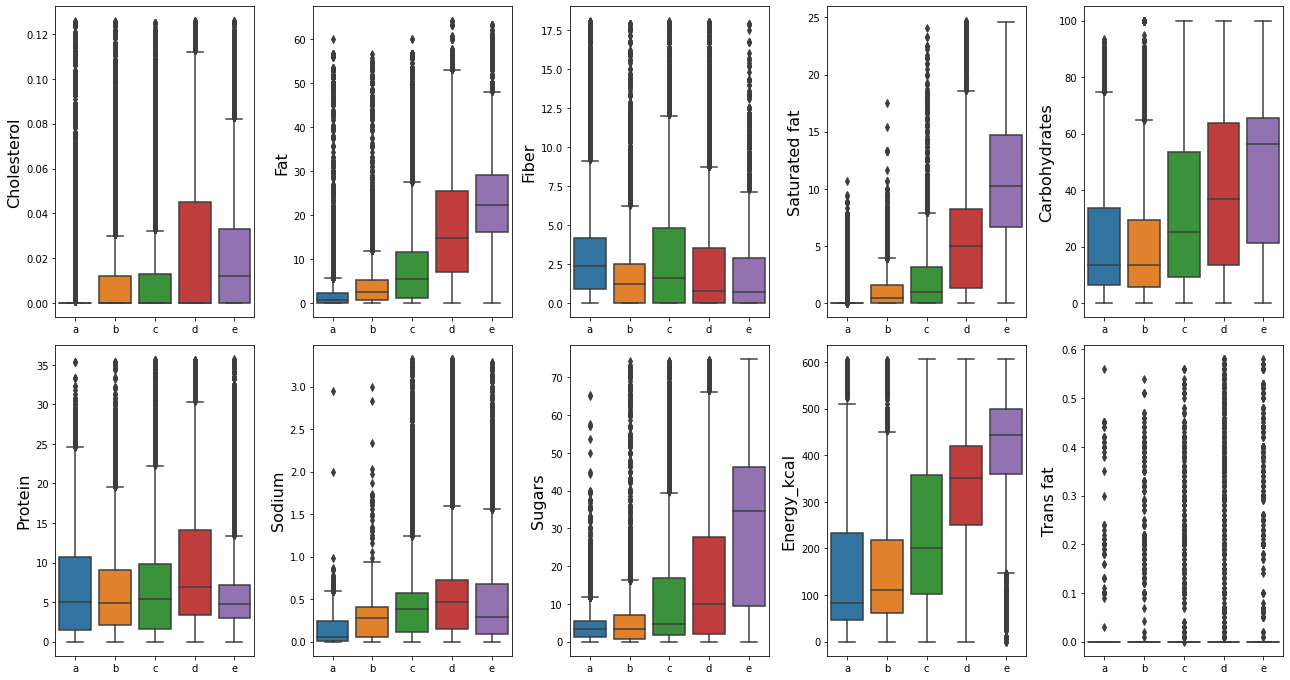

In [ ]:
plt.figure(figsize=(18,14))
plt.subplot(351)
boxplot_multi_nutri('Cholesterol')
# sns.boxplot(data=df_nutri, x='nutri_grade', y='Cholesterol', showfliers=False, order=order_nutri)
# plt.ylabel('Cholesterol', fontsize=12)
plt.subplot(352)
boxplot_multi_nutri('Fat')
plt.subplot(353)
boxplot_multi_nutri('Fiber')
plt.subplot(354)
boxplot_multi_nutri('Saturated fat')
plt.subplot(355)
boxplot_multi_nutri('Carbohydrates')
plt.subplot(356)
boxplot_multi_nutri('Protein')
plt.subplot(357)
boxplot_multi_nutri("Sodium")
# sns.boxplot(data=df_nutri, x='nutri_grade', y='Sodium', showfliers=False, order=order_nutri)
# plt.ylabel('Sodium', fontsize=12)
plt.subplot(358)
boxplot_multi_nutri('Sugars')
plt.subplot(359)
boxplot_multi_nutri('Energy_kcal')
plt.subplot(3,5,10)
boxplot_multi_nutri('Trans fat')

plt.tight_layout(pad=1)
plt.savefig("nutri_boxplot.jpg",dpi=300)
plt.show()

###Nutri & Nova

**Comment:** Before going into details aboout nutrition, let's first have a look at how the Nutri-grade and Nova-grade proportions of the products from OpenFoodFacts are distributed

In [ ]:
rawdata.loc[(rawdata.countries!="United States"), "countries"] = "Others"
notna = rawdata[(rawdata.nova_group.notna()) & (rawdata.nutriscore_grade.notna())]
notna = notna[["countries","nova_group","nutriscore_grade"]]
print(len(notna))
notna.head(2)

467935


,countries,nova_group,nutriscore_grade
72,Others,4.0,a
286,United States,3.0,c


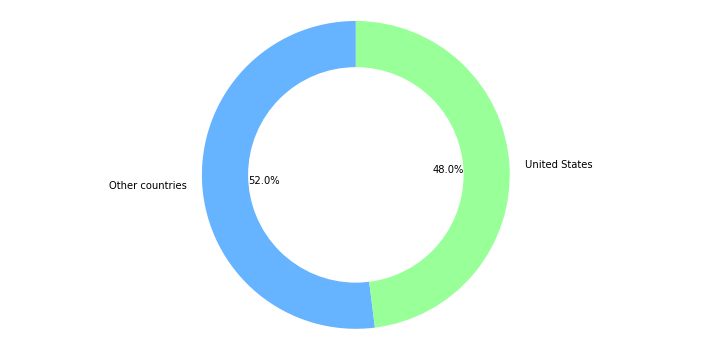

In [ ]:
plt.figure(figsize=(10,5))

ccount = notna.countries.value_counts()
labels = ["Other countries", "United States"]
plt.pie(ccount, colors=['#66b3ff','#99ff99'],labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

**Comments:** Among more than 450K food packages that have been graded, Products from US accounts for half of the products worldwide. Let's dive deeper into how the distritbution of each grading scale is for US compared to Worldwide

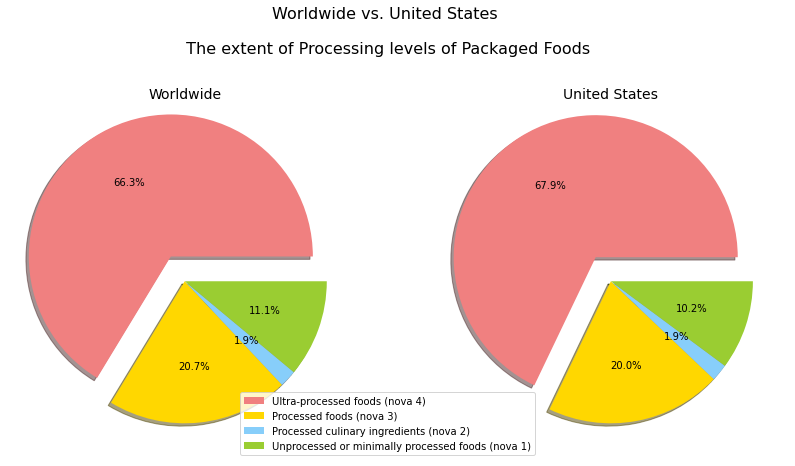

In [ ]:
#NOVA
plt.figure(figsize=(14,8))
plt.suptitle("Worldwide vs. United States\n\n The extent of Processing levels of Packaged Foods", size=16)

# Worldwide
plt.subplot(121)
nova_count = rawdata.nova_group.value_counts(normalize=True).sort_index(ascending=False)
labels_nova = ['Ultra-processed foods (nova 4)','Processed foods (nova 3)','Processed culinary ingredients (nova 2)','Unprocessed or minimally processed foods (nova 1)']
colors_nova = ['lightcoral','gold','lightskyblue','yellowgreen']
explode_nova = (0.2,0,0,0)
plt.pie(nova_count,colors=colors_nova, autopct = '%1.1f%%',counterclock=True, explode = explode_nova, shadow=True)
# plt.legend(labels_nova, loc='lower right')
plt.title('Worldwide', size=14)

# USA
plt.subplot(122)
nova_count = data.nova_group.value_counts(normalize=True).sort_index(ascending=False)

plt.pie(nova_count,colors=colors_nova, autopct = '%1.1f%%',counterclock=True, explode = explode_nova, shadow=True)
plt.title('United States', size=14)

plt.legend(labels_nova,loc = 'center right', bbox_to_anchor=(0.3, 0.1))

plt.show()

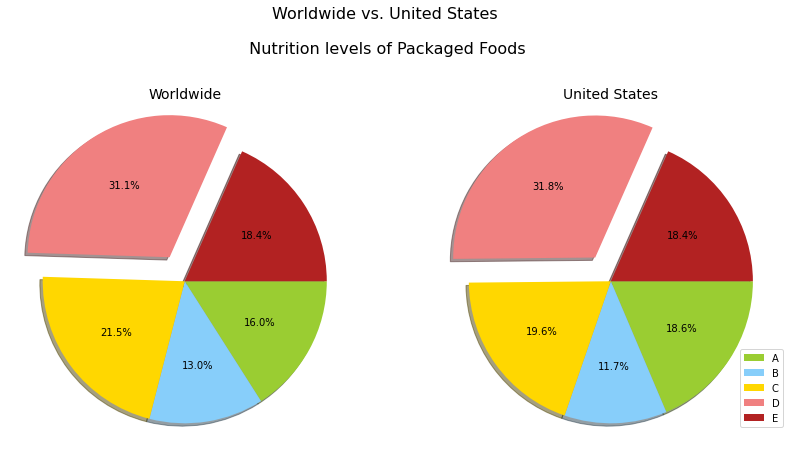

In [ ]:
#Nutri
plt.figure(figsize=(14,8))
plt.suptitle("Worldwide vs. United States\n\n Nutrition levels of Packaged Foods", size=16)

# Worldwide
plt.subplot(121)
nutri_count = rawdata.nutriscore_grade.value_counts(normalize=True).sort_index()
labels_nutri = ["A","B","C","D","E"]
colors_nutri = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_nutri = (0,0,0,0.2,0)

plt.pie(nutri_count,colors=colors_nutri, explode=explode_nutri,counterclock=False, autopct = '%1.1f%%', shadow=True)
plt.title('Worldwide', size=14)

# USA
plt.subplot(122)
nutri_count = data.nutriscore_grade.value_counts(normalize=True).sort_index()

plt.pie(nutri_count,colors=colors_nutri, explode=explode_nutri,counterclock=False, autopct = '%1.1f%%', shadow=True)
plt.title('United States', size=14)

plt.legend(labels_nutri,loc = 'center right', bbox_to_anchor=(1, 0.2))

plt.show()

**Comment**: About 70% of packaged foods from United States are heavily processed **NOVA 4**
This number is very consistent with most published reports of fast food in United States. Only a very smaller portion of food is unprocessed or minimally procssed.

Regarding **Nutri-grade**, nearly 50% of foods are given grade of D or E. ***So why not consider going Vegan?***

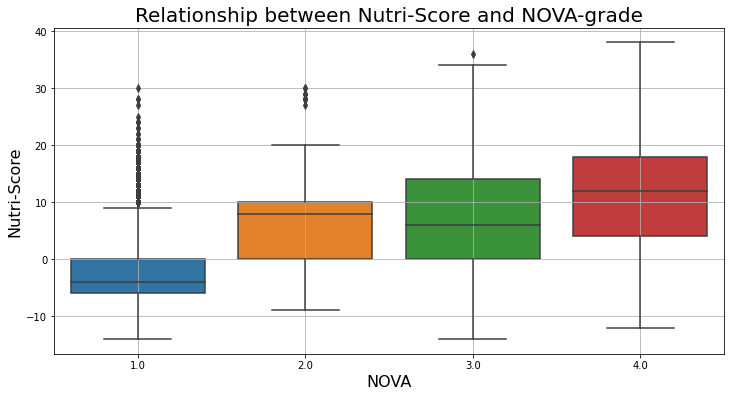

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="nova_grade", y="nutri_score")
plt.xlabel("NOVA", size=16)
plt.ylabel("Nutri-Score", size=16)
plt.title("Relationship between Nutri-Score and NOVA-grade", size=20)
plt.grid()
plt.savefig("nutri_nova.jpg",dpi=300)
plt.show()

This plot strongly suggests NOVA grade and Nutri has an underlying relationship, meaning it's definitely possible to predict NOVA based on nutrients

##Nutrient vs. Nutrient

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(df[df.Label!="Vegan"], x="Energy_kcal", y="Sugars", title="Energy/Sugars")
fig.show()

**Saturated fat** in Meat

In [ ]:
fig = px.scatter(df[df["Category"]=="Meat"], x="Fat", y="Saturated fat", title="Saturated fat/Fat")
fig.show()

**Comment** People consuming meat have higher chance of getting Saturated fat or the "Bad" fat

In [ ]:
data.Category.unique()

array(['Breads', 'Snacks', 'Desserts', 'Confectioneries', 'Sauces',
       'Plant-based beverages', 'Beverages', 'Meals', 'Vegetables',
       'Grains', 'Dairy', 'Seafood', 'Frozen foods', 'Pasta', 'Legumes',
       'Meat', 'Fruits'], dtype=object)

In [ ]:
cereals = data.loc[data.Name.str.contains(r"cereal", flags=re.IGNORECASE, regex=True)]

In [ ]:
fig = px.scatter(cereals, x="Sugars", y="Sodium", title="Sugars/Energy")
fig.show()

##Vegan vs. Meat

####Category-wise

Which **Categories** are the most common among the products?

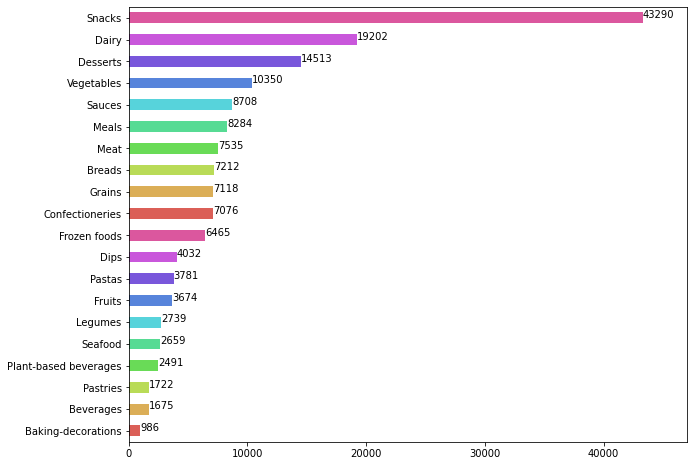

In [ ]:
# Top 20 categories
plt.figure(figsize=(10,8))
cat_count = data.Category.value_counts()[:20].sort_values()
cplot = cat_count.plot.barh(color = sns.color_palette('hls',10))
for i,v in enumerate(cat_count):
  cplot.text(v,i, str(v))
plt.xlim(right=47000)
plt.show()

Only the most common categories are used for further analysis

In [ ]:
cat = ["Snacks","Dairy","Desserts","Vegetables","Sauces","Meals","Meat","Grains","Breads","Confectioneries","Frozen foods","Pasta","Seafood","Fruits","Beverages","Legumes","Plant-based beverages","Beverages"]
data = data.loc[(data.Category.isin(cat))]
print(data.Category.unique())
print(len(data))

['Breads' 'Snacks' 'Desserts' 'Confectioneries' 'Sauces'
 'Plant-based beverages' 'Beverages' 'Meals' 'Vegetables' 'Grains' 'Dairy'
 'Seafood' 'Frozen foods' 'Pasta' 'Legumes' 'Meat' 'Fruits']
153939


###Is Vegan better?

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    17755
Vegan          842
Name: Label, dtype: int64

Let's separate the products into "Vegan/Non Vegan"

In [ ]:
data.loc[(data.Label.str.contains(r"veg", flags=re.IGNORECASE, regex=True)) & (data.Label != "Non Vegan"), "Label"] = "Vegan"

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    17755
Vegan         1098
Name: Label, dtype: int64

In [ ]:
veg = ["Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein","Plant-based-foods","Plant-based beverages"]
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.isin(veg),"Label"] = "Vegan"

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Vegan        27693
Non Vegan    17560
Name: Label, dtype: int64

In [ ]:
non_veg = ["Seafood"]
data.loc[data.Category.isin(non_veg),"Label"] = "Non Vegan"

data.loc[data.Name.str.contains(r"eggs") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 
data.loc[(data.Category=="Meat") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 
# data.loc[(data.Category=="Dairy") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"
# data.loc[(data.Category=="Beverages") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"
# data.loc[(data.Category=="Frozen foods") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"

In [ ]:
# veg = ["Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein","Plant-based-foods","Plant-based beverages"]
# non_veg = ["Meat", "Seafood", "Eggs", "Meals", "Beverages",""]

# data.loc[data.Category.isin(veg),"Label"] = "Vegan"

# data.loc[data.Category.isin(non_veg),"Label"] = "Non Vegan"
# data.loc[(data.Category=="Dairy") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"

# data.loc[data.Label.str.contains("Vegetarian"), "Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"Vegan egg", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"(cheese|parmesan|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Label"] = "Non Vegan"
# data.loc[(data.Category.str.contains(r"(Plant milks)", flags=re.IGNORECASE, regex=True)), "Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"


In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Vegan        27693
Non Vegan    27589
Name: Label, dtype: int64

In [ ]:
# cat_vm = ["Meat", "Seafood", "Eggs", "Dairy", "Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein"]
# veg_df = df.loc[(df.Category.isin(cat_vm)) | (df.Label.isin(["Vegan"]))]

In [ ]:
veg_df = data[data.Label.isin(["Vegan","Non Vegan"])]
veg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55282 entries, 45 to 190803
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             55282 non-null  object 
 1   Ingredients      55282 non-null  object 
 2   Category         55282 non-null  object 
 3   Label            55282 non-null  object 
 4   nutri_score      55282 non-null  float64
 5   nutri_grade      55282 non-null  object 
 6   nova_grade       55282 non-null  float64
 7   Cholesterol      55282 non-null  float64
 8   Fat              55282 non-null  float64
 9   Sodium           55282 non-null  float64
 10  Sugars           55282 non-null  float64
 11  Carbohydrates    55282 non-null  float64
 12  Protein          55282 non-null  float64
 13  Saturated fat    55282 non-null  float64
 14  Fiber            55282 non-null  float64
 15  Trans fat        55282 non-null  float64
 16  Energy_kcal      55282 non-null  float64
 17  additives 

In [ ]:
veg_df = veg_df.drop(columns=["Ingredients","nutri_score"])

In [ ]:
veg_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/veg_df.csv", index=False)

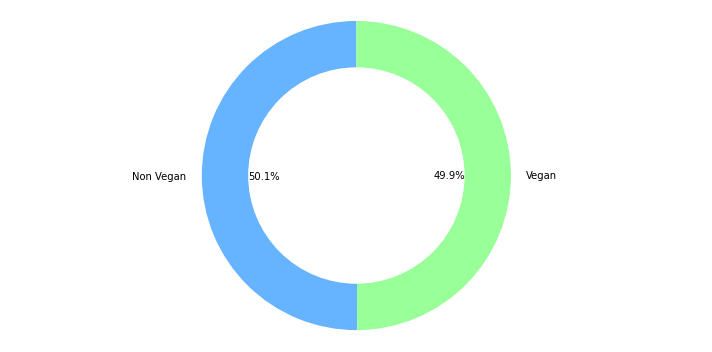

In [ ]:
plt.figure(figsize=(10,5))

lcount = veg_df.Label.value_counts()
labels = ["Non Vegan","Vegan"]
plt.pie(lcount, colors=['#66b3ff','#99ff99'],labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

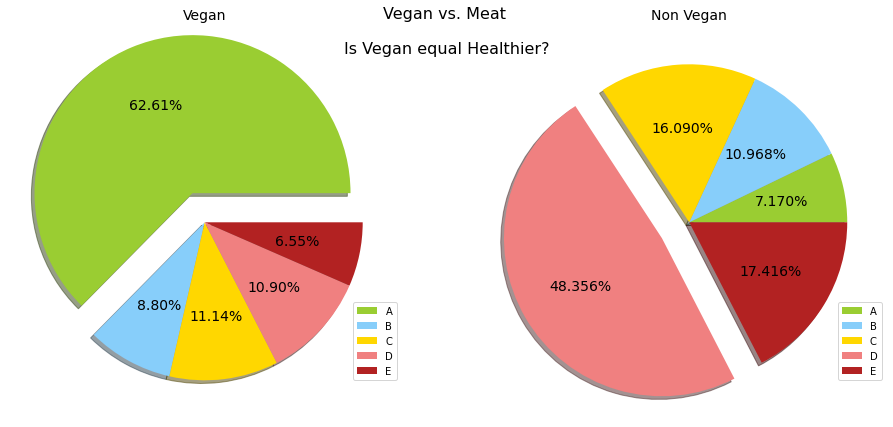

In [ ]:
plt.figure(figsize=(14,6))
plt.suptitle("Vegan vs. Meat \n\nIs Vegan equal Healthier?", size = 16)
# Vegan
plt.subplot(121)
nutri_v = veg_df[veg_df.Label=="Vegan"].nutri_grade.value_counts().sort_index()
labels = ["A","B","C","D","E"]
colors = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_v = (0.2,0,0,0,0)
plt.title('Vegan', size = 14)
plt.pie(nutri_v, colors=colors, autopct = '%1.2f%%', explode=explode_v, counterclock=True, shadow=True, textprops={'fontsize':14})
plt.legend(labels,loc = 'center right', bbox_to_anchor=(1, 0.2))
# Non vegan
plt.subplot(122)
nutri_n = veg_df[veg_df.Label=="Non Vegan"].nutri_grade.value_counts().sort_index()
colors_nv = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_n = (0,0,0,0.2,0)
plt.title('Non Vegan', size = 14)
plt.pie(nutri_n, colors=colors_nv, autopct = '%1.3f%%', explode=explode_n, counterclock=True, shadow=True, textprops={'fontsize':14})

plt.legend(labels,loc = 'center right', bbox_to_anchor=(1, 0.2))
plt.tight_layout(pad=1)

plt.show()

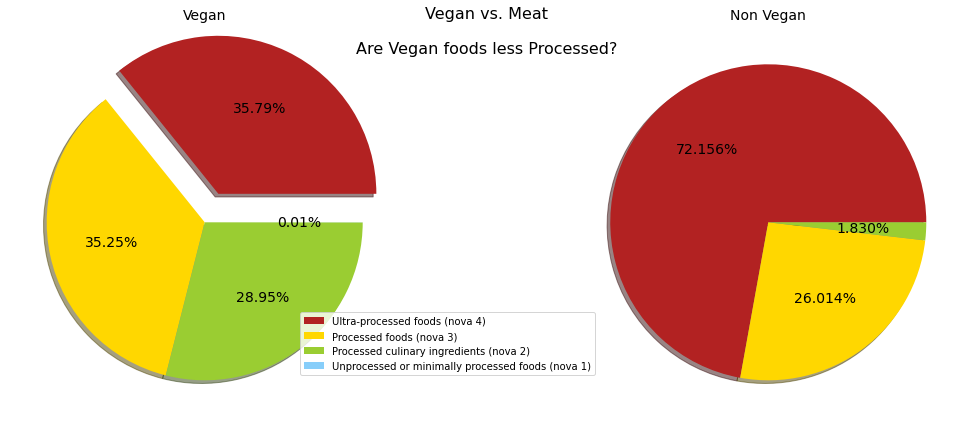

In [ ]:
plt.figure(figsize=(14,6))
plt.suptitle("Vegan vs. Meat\n\nAre Vegan foods less Processed?", size = 16)
# Vegan
plt.subplot(121)
nova_v = veg_df[veg_df.Label=="Vegan"].nova_grade.value_counts()
labels_v = ['Ultra-processed foods (nova 4)','Processed foods (nova 3)','Processed culinary ingredients (nova 2)','Unprocessed or minimally processed foods (nova 1)']
colors_v = ['firebrick','gold','yellowgreen','lightskyblue']
explode_v = (0.2,0,0,0)

plt.title('Vegan', size = 14)
plt.pie(nova_v, colors=colors_v, autopct = '%1.2f%%', explode=explode_v, counterclock=True, shadow=True, textprops={'fontsize':14})
plt.legend(labels_v,loc = 'lower right', bbox_to_anchor=(1.5, 0.1))

#Non vegan
plt.subplot(122)
nova_n = veg_df[veg_df.Label=="Non Vegan"].nova_grade.value_counts()
colors_n = ['firebrick','gold', 'yellowgreen','lightskyblue']
# explode_n = (0.2,0,0,0)

plt.title('Non Vegan', size = 14)
plt.pie(nova_n, colors=colors_n, autopct = '%1.3f%%',  counterclock=True, shadow=True, textprops={'fontsize':14})

# plt.legend(labels_v,loc = 'center right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout(pad=1)
plt.savefig("veg_nutri.jpg", dpi=300)

###Exploring the Nutrients

####Bad Nutrients

Top **Sodium-rich** Foods

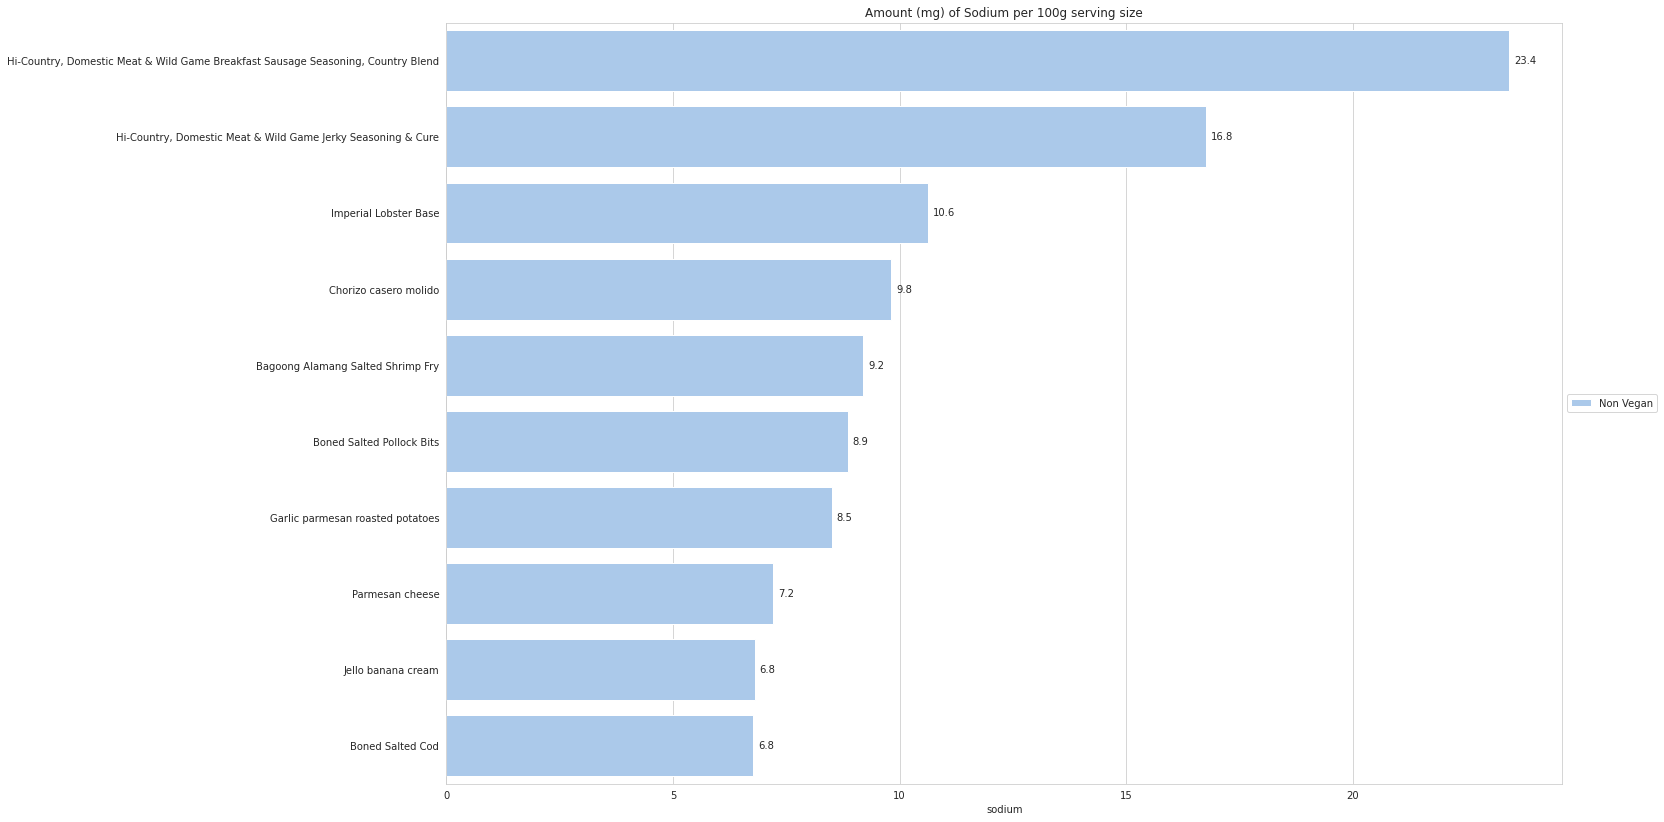

In [ ]:
sodium = veg_df.sort_values("Sodium", ascending=False)
sodium_10 = sodium.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=sodium_10, y="Name", x="Sodium", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sodium")
plt.ylabel("")
plt.title("Amount (g) of Sodium per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

Top **Saturated fat** rich Foods

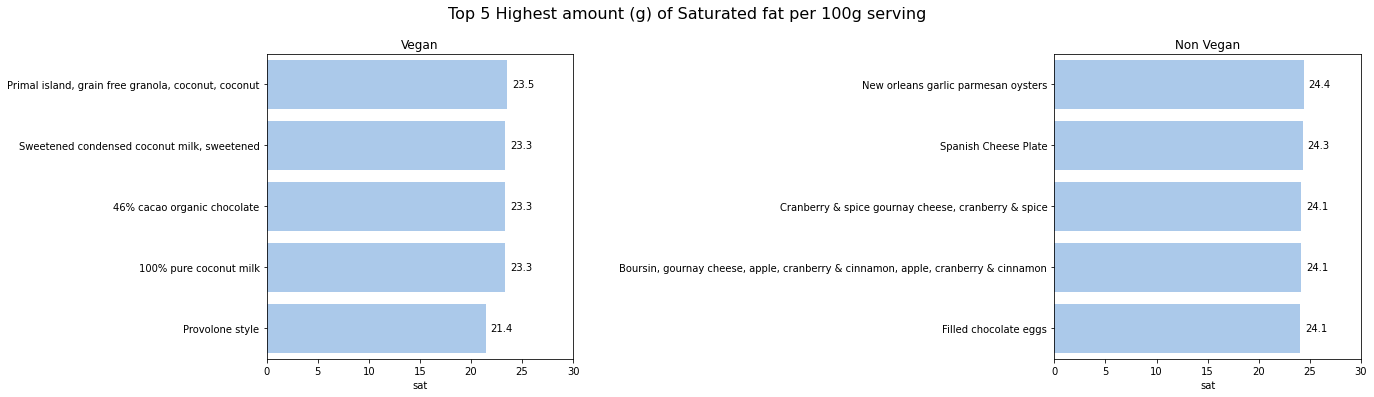

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle("Top 5 Highest amount (g) of Saturated fat per 100g serving", size=16)

#Vegan
plt.subplot(121)
sat = veg_df[veg_df["Label"]=="Vegan"].sort_values("Saturated fat", ascending=False)
sat_5 = sat.head(5)

cplot = sns.barplot(data=sat_5, y="Name", x="Saturated fat", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sat")
plt.ylabel("")
plt.title("Vegan", size=12)
# plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
cplot.legend([],[], frameon=False)
plt.xlim(right=30)

#Non
plt.subplot(122)
sat = veg_df[veg_df["Label"]=="Non Vegan"].sort_values("Saturated fat", ascending=False)
sat_5 = sat.head(5)

cplot = sns.barplot(data=sat_5, y="Name", x="Saturated fat", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sat")
plt.ylabel("")
plt.title("Non Vegan", size=12)
# plt.legend(loc="upper left",  bbox_to_anchor=(0,1))
cplot.legend([],[], frameon=False)
plt.xlim(right=30)

plt.tight_layout(pad=4)
plt.show()

Top **Cholesterol-rich** foods

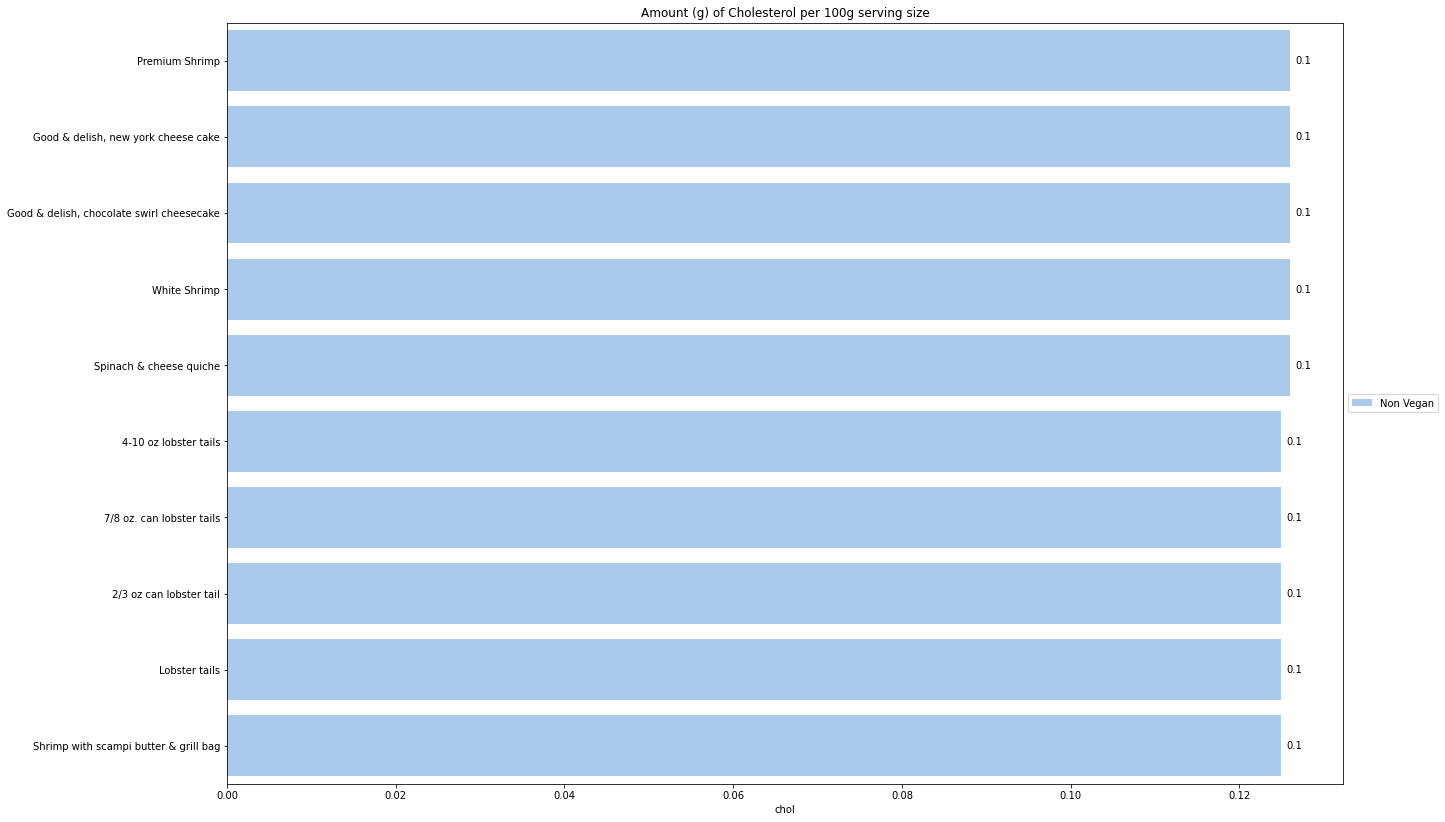

In [ ]:
chol = veg_df.sort_values("Cholesterol", ascending=False)
chol_10 = chol.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=chol_10, y="Name", x="Cholesterol", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("chol")
plt.ylabel("")
plt.title("Amount (g) of Cholesterol per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

Top **Sugar-rich** Foods

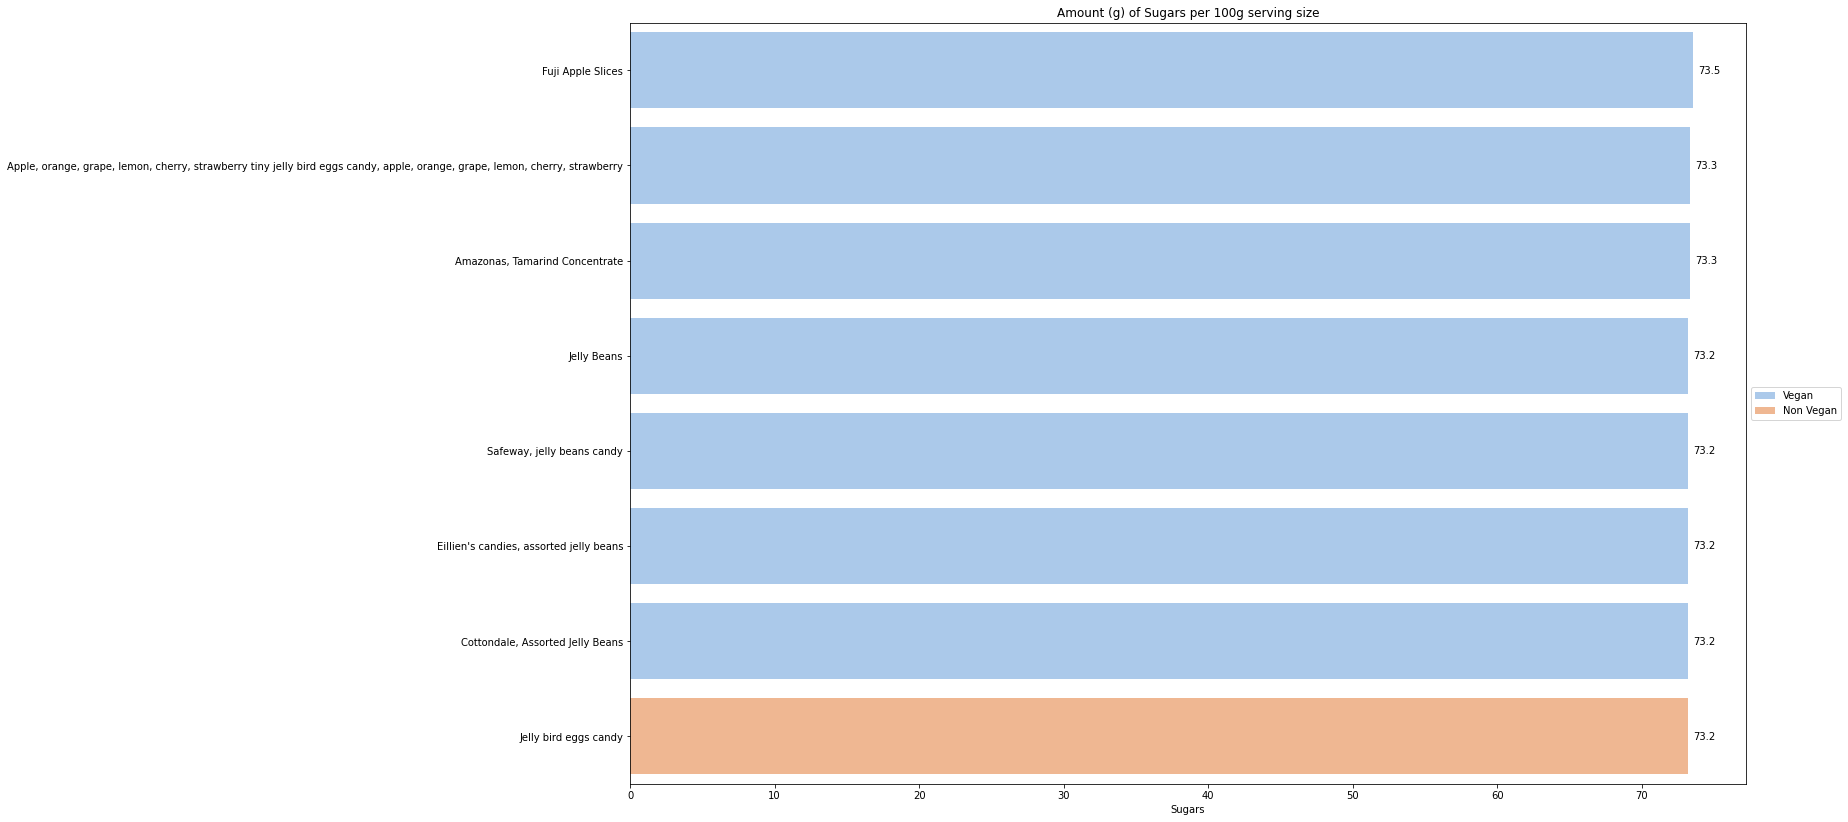

In [ ]:
sug = veg_df.sort_values("Sugars", ascending=False)
sug_10 = sug.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=sug_10, y="Name", x="Sugars", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Sugars")
plt.ylabel("")
plt.title("Amount (g) of Sugars per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

####Good Nutrients

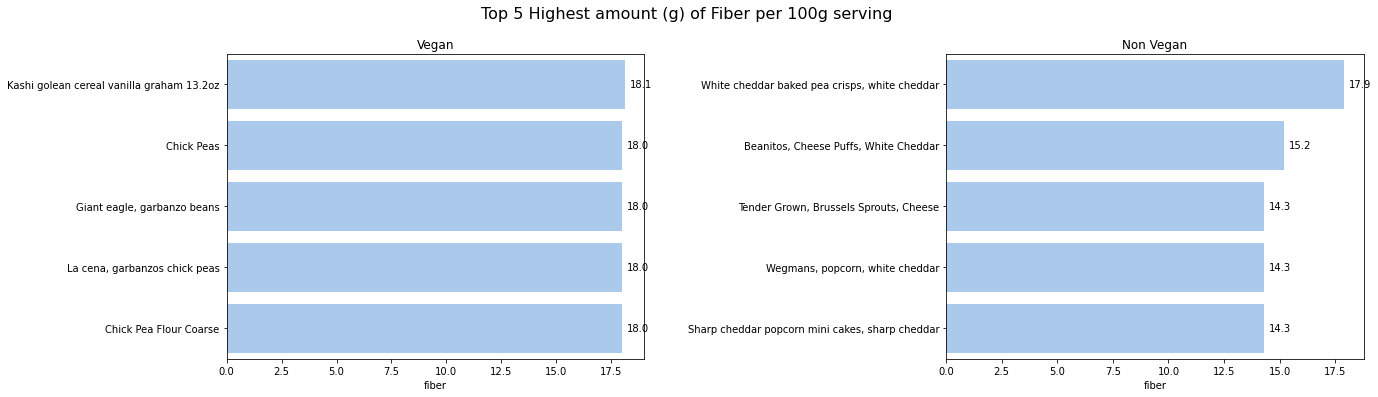

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle("Top 5 Highest amount (g) of Fiber per 100g serving", size=16)

#Vegan
plt.subplot(121)
fiber = veg_df[veg_df["Label"]=="Vegan"].sort_values("Fiber", ascending=False)
fiber_5 = fiber.head(5)

cplot = sns.barplot(data=fiber_5, y="Name", x="Fiber", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("fiber")
plt.ylabel("")
plt.title("Vegan", size=12)
# plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
cplot.legend([],[], frameon=False)
# plt.xlim(right=115)

#Non
plt.subplot(122)
fiber = veg_df[veg_df["Label"]=="Non Vegan"].sort_values("Fiber", ascending=False)
fiber_5 = fiber.head(5)

cplot = sns.barplot(data=fiber_5, y="Name", x="Fiber", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("fiber")
plt.ylabel("")
plt.title("Non Vegan", size=12)
# plt.legend(loc="upper left",  bbox_to_anchor=(0,1))
cplot.legend([],[], frameon=False)
# plt.xlim(right=25)

plt.tight_layout(pad=4)
plt.show()

Top **Protein-rich** foods

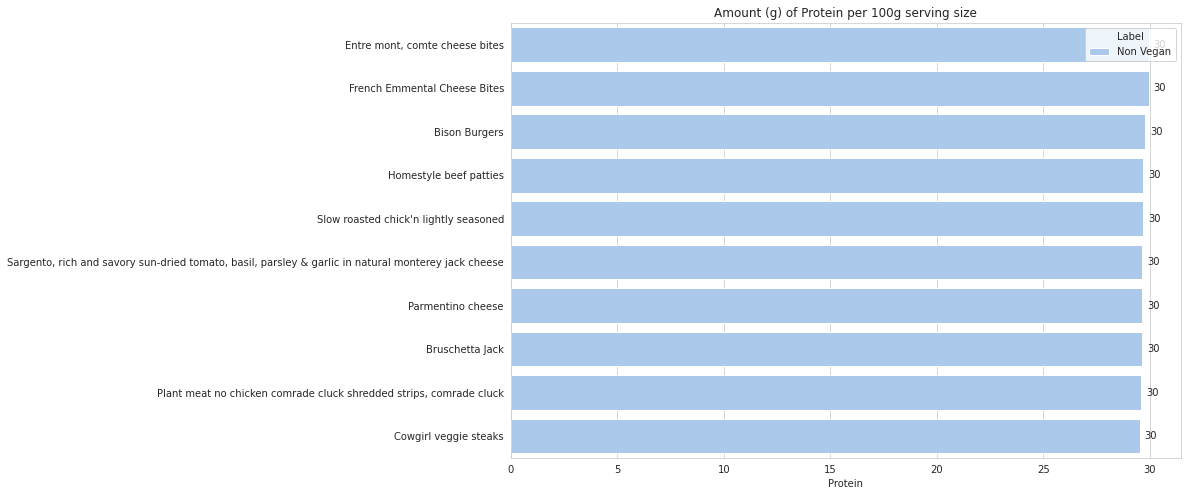

In [ ]:
pro = veg_df.sort_values("Protein", ascending=False)
pro_10 = pro.head(10)
plt.figure(figsize=(12,8))
sns.set_color_codes("pastel")
pplot = sns.barplot(data=pro_10, y="Name", x="Protein", hue="Label",palette = 'pastel', dodge=False)
for p in pplot.patches:
    pplot.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Protein")
plt.ylabel("")
plt.title("Amount (g) of Protein per 100g serving size")
plt.show()

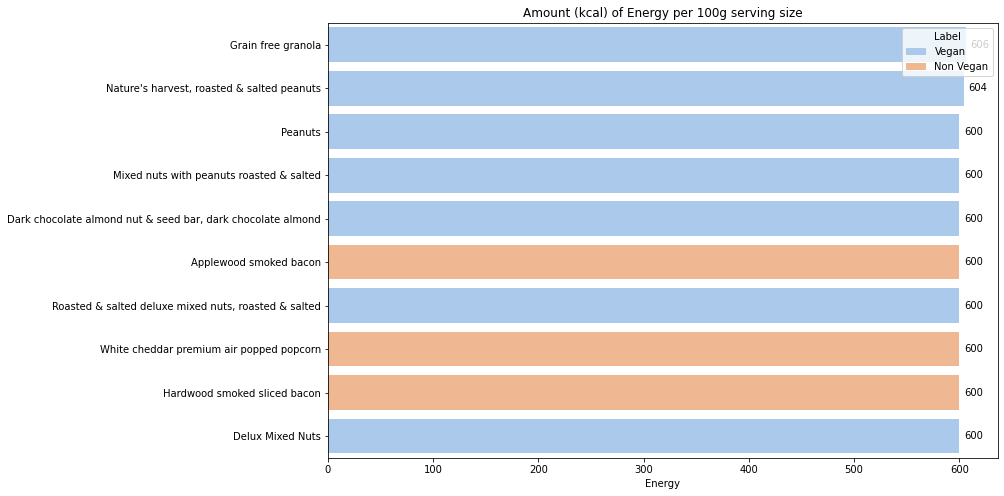

In [ ]:
ener = veg_df.sort_values("Energy_kcal", ascending=False)
ener_10 = ener.head(10)
plt.figure(figsize=(12,8))
sns.set_color_codes("pastel")
pplot = sns.barplot(data=ener_10, y="Name", x="Energy_kcal", hue="Label",palette = 'pastel', dodge=False)
for p in pplot.patches:
    pplot.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Energy")
plt.ylabel("")
plt.title("Amount (kcal) of Energy per 100g serving size")
plt.show()

##Nutrition Category-wise

In [ ]:
df = veg_df[veg_df.Category.isin(['Dairy', 'Vegetables', 'Meat', 'Grains', 'Fruits', 'Legumes', 'Seafood',
       'Plant-based beverages', 'Snacks', 'Frozen foods', 'Meals', 'Pasta',
       'Desserts', 'Pastas', 'Sauces', 'Breads'])]

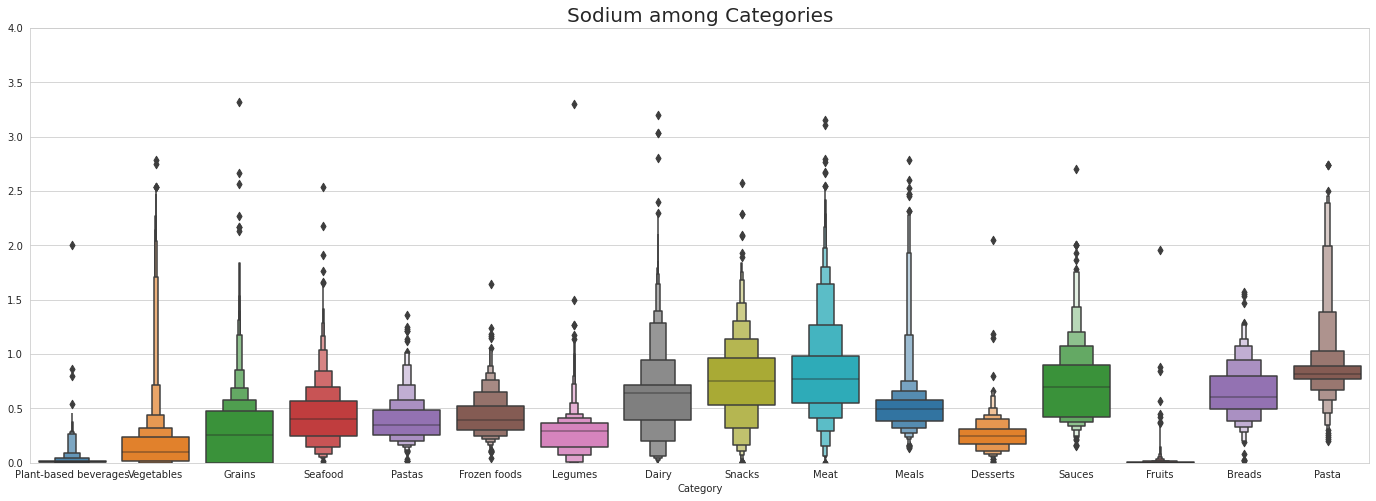

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(24,8))

ax = sns.boxenplot(x="Category", y='Sodium', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.title("Sodium among Categories", size=20)
plt.ylim(bottom=0, top=4)
plt.ylabel("")
plt.show()

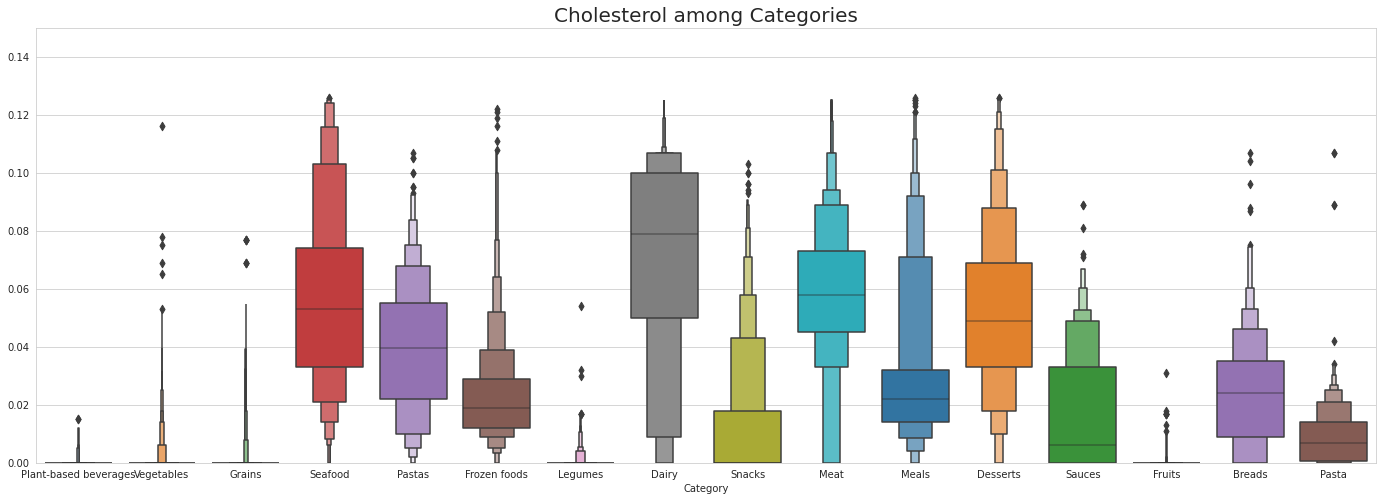

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(24,8))

ax = sns.boxenplot(x="Category", y='Cholesterol', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.title("Cholesterol among Categories", size=20)
plt.ylim(bottom=0, top=0.15)
plt.ylabel("")
plt.show()

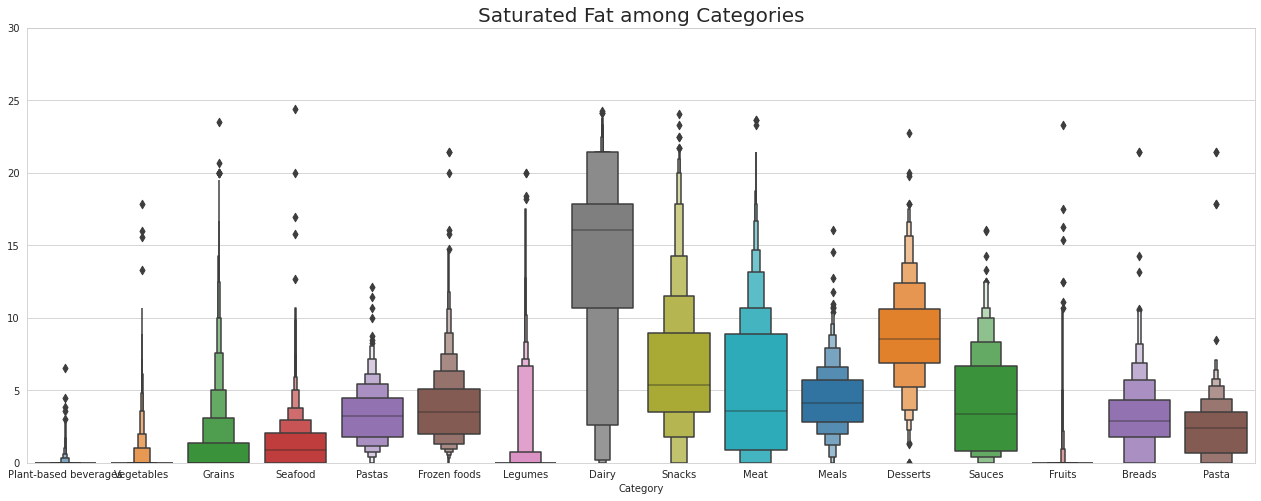

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

ax = sns.boxenplot(x="Category", y='Saturated fat', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Saturated Fat among Categories", size=20)
plt.ylim(bottom=0, top=30)
plt.ylabel("")
plt.show()

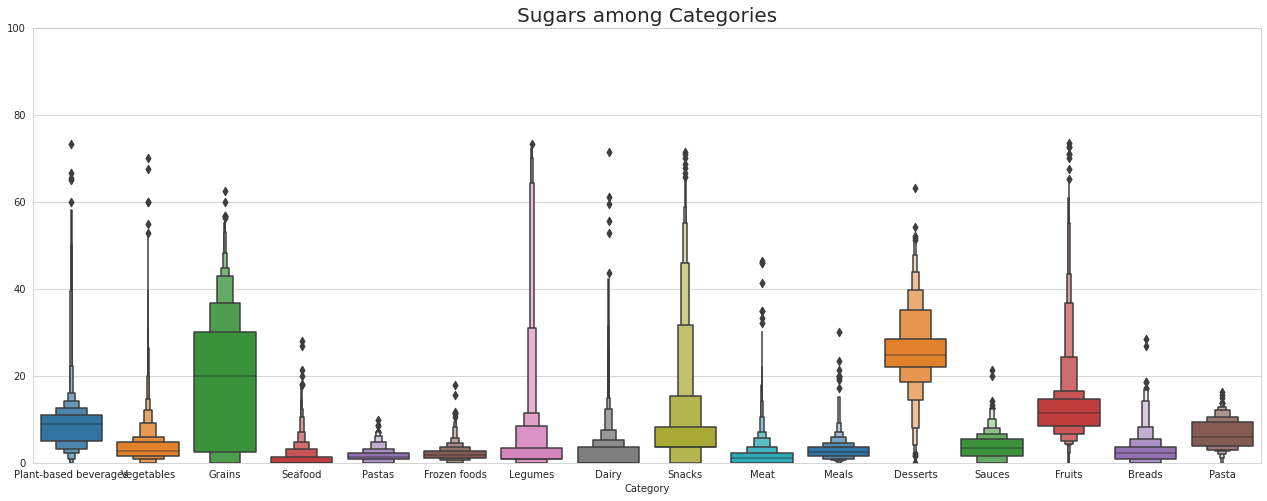

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

ax = sns.boxenplot(x="Category", y='Sugars', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Sugars among Categories", size=20)
plt.ylim(bottom=0, top=100)
plt.ylabel("")
plt.show()

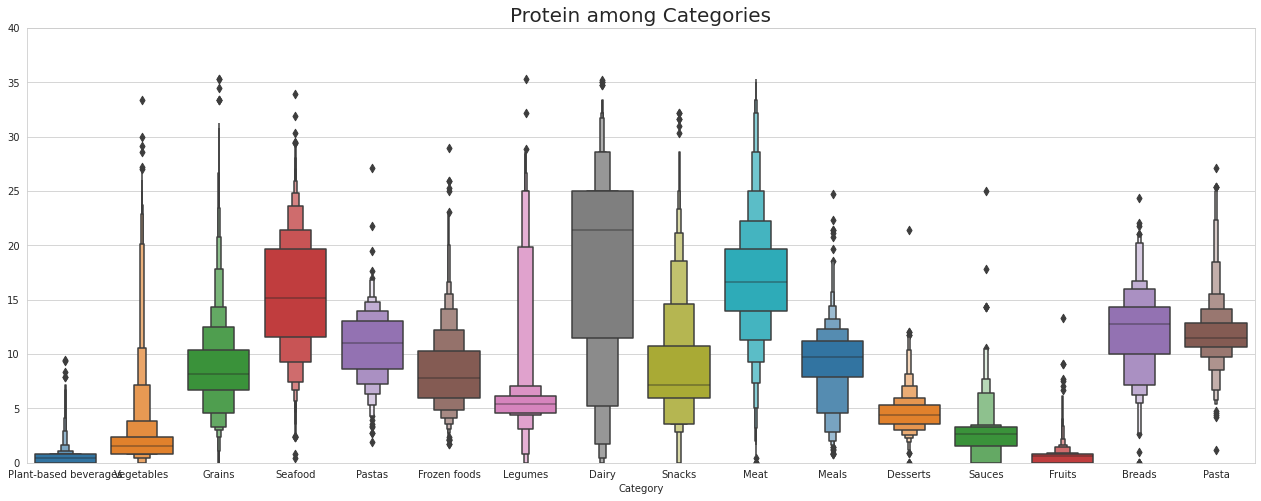

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

ax = sns.boxenplot(x="Category", y='Protein', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Protein among Categories", size=20)
plt.ylim(bottom=0, top=40)
plt.ylabel("")
plt.show()

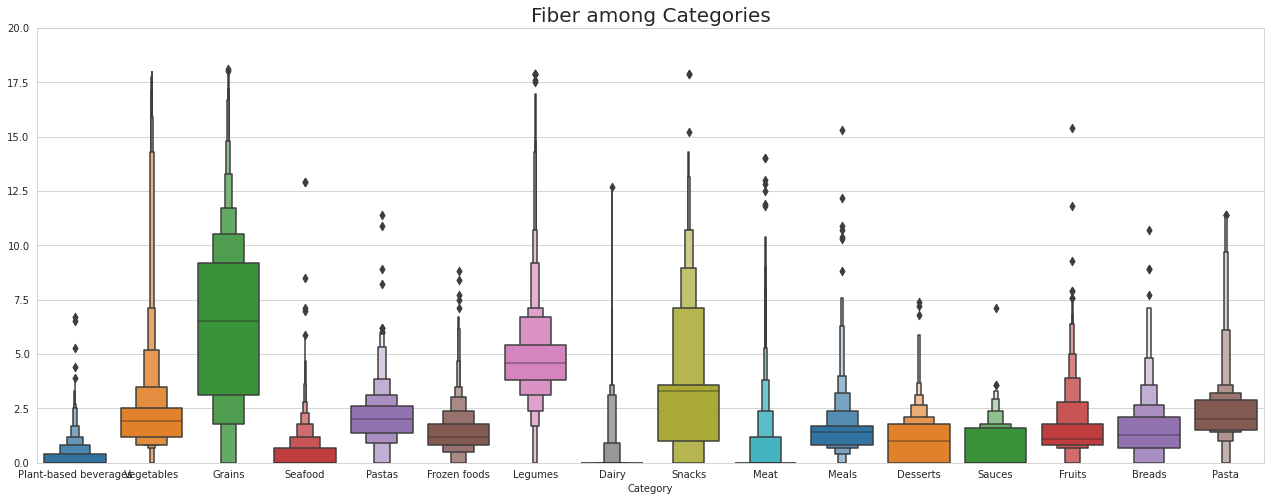

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

ax = sns.boxenplot(x="Category", y='Fiber', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
    
plt.title("Fiber among Categories", size=20)
plt.ylim(bottom=0, top=20)
plt.ylabel("")
plt.show()

##Additives

###Why additives?

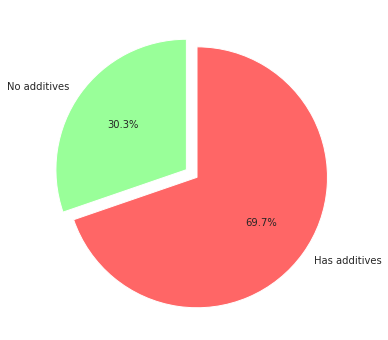

In [ ]:
plt.figure(figsize=(10,6))
with_adds = data[data["Additives_count"]>0]
no_adds = data[data["Additives_count"]==0]
labels= ["No additives","Has additives"]
colors = ['#99ff99','#ff6666']
plt.pie([len(no_adds),len(with_adds)], colors=colors, labels=labels, autopct='%.1f%%',startangle=90, explode=(0,0.1))

plt.show()

Does Additives really affect the nutrition value?

In [ ]:
additives_by_grade = data.groupby("nutri_grade")["Additives_count"]

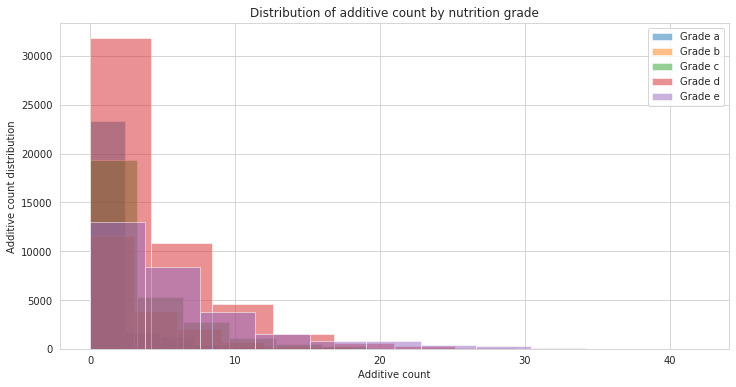

In [ ]:
plt.figure(figsize=(12,6))
for additive, grade in additives_by_grade:
    plt.hist(grade, label = "Grade {}".format(additive), alpha = 0.5)
plt.title("Distribution of additive count by nutrition grade")
plt.xlabel("Additive count")
plt.ylabel("Additive count distribution")
plt.legend()
plt.show()

It seems like the distribution of additives count for each grade is similar. However, we can see that Grade D is the dominant grade in the total products

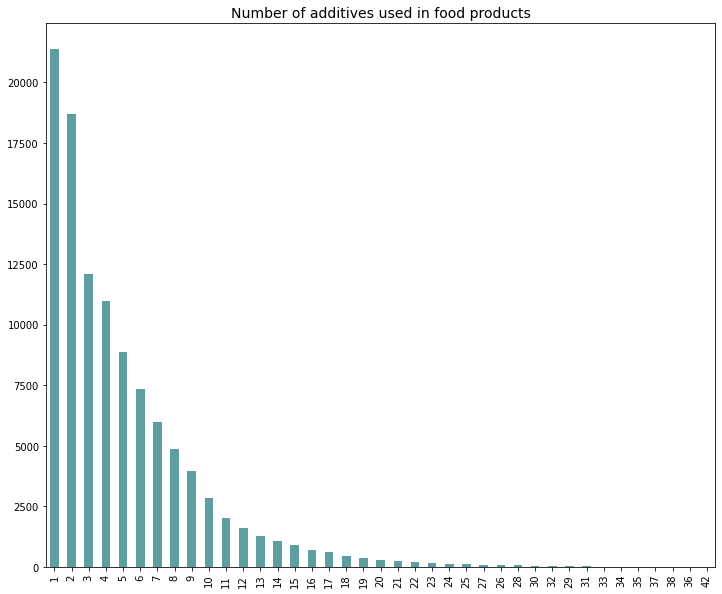

In [ ]:
plt.figure(figsize=(12,10))
df[df['Additives_count'] > 0]['Additives_count'].value_counts().plot(kind='bar',color='cadetblue')
plt.title('Number of additives used in food products',fontsize=14)
plt.show()

####Let's dive deeper into the additives

In [ ]:
additives = (df['additives'].str.extractall("(?P<Count>[E]\d\d\d\w?)"))
additives_count = additives.apply(pd.value_counts).head(30)
additives_count['Enum'] = additives_count.index
additives_count.reset_index(drop=True,inplace=True)

In [ ]:
additives_mapping = {'E330': 'orange','E322':'purple','E322i':'purple','E101':'blue','E375':'orange','E101i':'blue',
                    'E300':'cyan','E415':'purple','E412':'orange','E500':'orange','E471':'purple','E203':'forestgreen','E407':'purple',
                    'E440':'purple','E250':'forestgreen','E150a':'blue','E450':'orange','E500i':'blue','E331':'orange',
                     'E129':'orange','E339':'orange','E440i':'purple','E160a':'blue','E270':'orange','E102':'blue',
                     'E410':'purple','E133':'blue','E341':'orange','E428':'purple','E621':'orange','E202':'blue','E150c':'blue','E200':'forestgreen','E282':'forestgreen','E316':'cyan',
                     'E341i':'cyan','E160b':'blue','E110':'blue','E211':'forestgreen','E414':'purple','E422':'orange','E450i':'orange','E466':'purple'}

additives_count['Colors'] = additives_count['Enum'].map(additives_mapping)

In [ ]:
def add_check(row):
  if row == "blue":
    return "Colors"
  elif row == "orange":
    return "Others"
  elif row == "purple":
    return "Emulsifiers"
  elif row == "orchid":
    return "Sweeteners"
  elif row == "cyan":
    return "Antioxidants"
  elif row == "forestgreen":
    return "Preservatives"

In [ ]:
additives_count["Type"] = additives_count["Colors"].apply(add_check)
additives_count.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/additives_count.csv", index=False)
additives_count

,Count,Enum,Colors,Type
0,46882,E330,orange,Others
1,40553,E322,purple,Emulsifiers
2,40479,E322i,purple,Emulsifiers
3,23912,E500i,blue,Colors
4,23907,E500,orange,Others
5,23447,E415,purple,Emulsifiers
6,19147,E412,orange,Others
7,18468,E471,purple,Emulsifiers
8,13830,E202,blue,Colors
9,13709,E407,purple,Emulsifiers


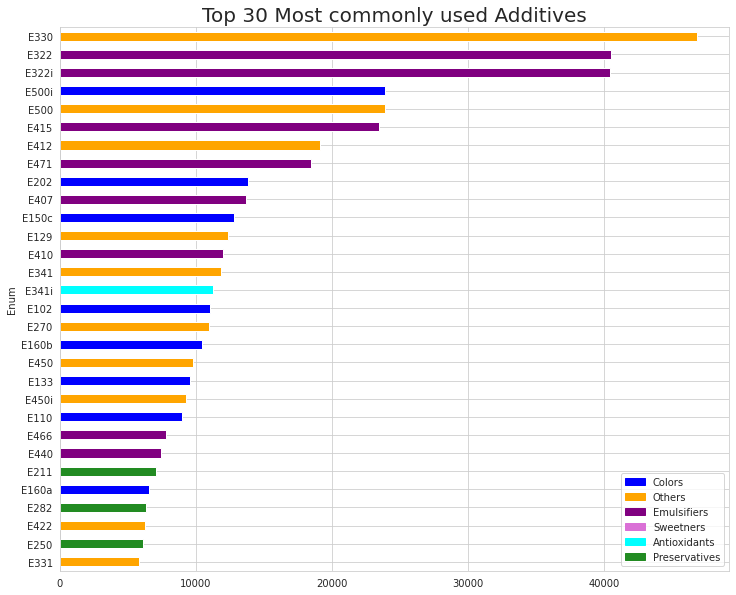

In [ ]:
import matplotlib.patches as mpatches

aplot = additives_count.plot(x='Enum',y='Count',kind='barh',color=additives_count['Colors'],figsize=(12,10))
aplot.invert_yaxis()
aplot.legend().set_visible(False)
aplot.set_title('Top 30 Most commonly used Additives',{'fontsize':20})

colors = mpatches.Patch(color='blue', label='Colors')
others = mpatches.Patch(color='orange', label='Others')
emulsifiers = mpatches.Patch(color='purple', label='Emulsifiers')
sweetners = mpatches.Patch(color='orchid', label='Sweetners')
antioxidant = mpatches.Patch(color='cyan', label='Antioxidants')
preservatives = mpatches.Patch(color='forestgreen', label='Preservatives')

plt.legend(handles=[colors,others,emulsifiers,sweetners,antioxidant,preservatives])
plt.savefig("30adds.jpg",dpi=300)
plt.show()

###Category-wise

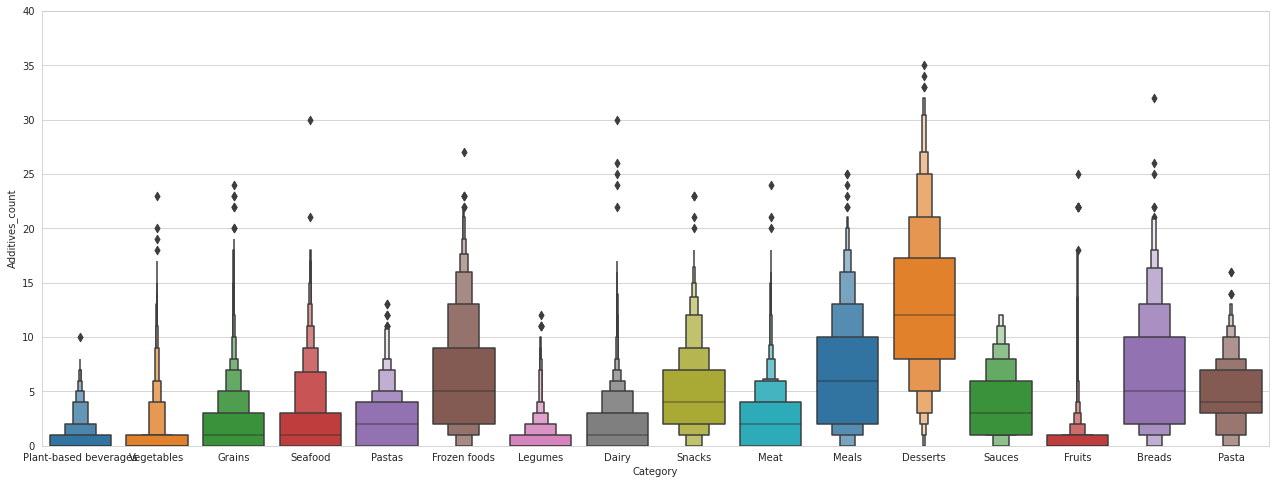

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))
ax = sns.boxenplot(x="Category", y='Additives_count', data=df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.ylim(bottom=0, top=40)
# plt.savefig("adds_cat.jpg",dpi=300)
plt.show()

###Which product has the most Additives

In [ ]:
data[(data.Additives_count == data[data["Label"]=="Non Vegan"]["Additives_count"].max()) & (data.Label=="Non Vegan")][["Name","Ingredients","nutri_grade","nova_grade","additives", "Additives_count"]]

,Name,Ingredients,nutri_grade,nova_grade,additives,Additives_count
250543,"The bakery, apple pie mini cupcakes, cinnamon cream cheese","Sugar, water, bleached enriched wheat flour (flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid), vegetable oil (soybean, palm, palm kernel, canola), cornstarch, eggs, corn syrup, nonfat milk, leavening (sodium acid pyrophosphate, baking soda, monocalcium phosphate, sodium aluminum phosphate, aluminum sulfate), egg whites, salt, food starch-modified, mono - and diglycerides, whey, malic acid, wheat starch, natural & artificial flavors, soy lecithin, citrus fiber, cinnamon, polyglycerol esters of fatty acids, xanthan gum, polysorbate 60, glycerin, gum arabic, potassium sorbate (preservative), sodium stearoyl lactylate, fructose, wheat protein, datem, calcium stearoyl-2-lactylate, cellulose, cream cheese powder (cream cheese (pasteurized milk, cheese culture, salt, carob bean gum), sodium caseinate (milk), disodium phosphate, natural flavor, bha), sodium carboxymethylcellulose, methylcellulose, caramel color, beta carotene (color), sucralose, turmeric color, paprika, yellow 5 lake, yellow 6 lake, red 40 lake, blue 1 lake.",e,4.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E129 - Allura red ac,E133 - Brilliant blue FCF,E150c - Ammonia caramel,E160a - Carotene,E160ai - Beta-carotene,E202 - Potassium sorbate,E296 - Malic acid,E320 - Butylated hydroxyanisole (bha),E322 - Lecithins,E322i - Lecithin,E339ii - Disodium phosphate,E341 - Calcium phosphates,E341i - Monocalcium phosphate,E410 - Locust bean gum,E414 - Acacia gum,E415 - Xanthan gum,E422 - Glycerol,E435 - Polyoxyethylene sorbitan monostearate,E450 - Diphosphates,E450i - Disodium diphosphate,E460 - Cellulose,E461 - Methyl cellulose,E466 - Sodium carboxy methyl cellulose,E471 - Mono- and diglycerides of fatty acids,E472e - Mono- and diacetyltartaric acid esters of mono- and diglycerides of fatty acids,E475 - Polyglycerol esters of fatty acids,E481 - Sodium stearoyl-2-lactylate,E482 - Calcium stearoyl-2-lactylate,E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E520 - Aluminium sulphate,E541 - Sodium aluminium phosphate,E955 - Sucralose",35


In [ ]:
data[(data.Additives_count == data[data["Label"]=="Vegan"]["Additives_count"].max()) & (data.Label=="Vegan")][["Name","Ingredients","nutri_grade","nova_grade","additives", "Additives_count"]]

,Name,Ingredients,nutri_grade,nova_grade,additives,Additives_count
135327,Chiffon mist creme dessert,"Water, sugar, high fructose corn syrup, mandarin oranges, pineapple (pineapple, pineapple juice), hydrogenated palm kernel oil, coconut oil, nonfat dry milk, strawberries, modified corn starch, gelatin, maraschino cherries, lactic acid, mono & diglycerides, citric acid, potassium sorbate & sodium benzoate (preservatives), corn syrup, citrus fiber, natural & artificial flavors, locust bean gum, sodium citrate, xanthan gum, sunflower lecithin, salt, guar gum, dextrose, polysorbate 60, polyglycerol esters of fatty acids, methylcellulose, soy lecithin, disodium phosphate, carrageenan, red 40, beta carotene (color), yellow 6, oil of bitter almond, red 3, yellow 5, caramel color, blue 1.",c,4.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E127 - Erythrosine,E129 - Allura red ac,E133 - Brilliant blue FCF,E150c - Ammonia caramel,E160a - Carotene,E160ai - Beta-carotene,E202 - Potassium sorbate,E211 - Sodium benzoate,E270 - Lactic acid,E322 - Lecithins,E322i - Lecithin,E330 - Citric acid,E331 - Sodium citrates,E339ii - Disodium phosphate,E407 - Carrageenan,E410 - Locust bean gum,E412 - Guar gum,E415 - Xanthan gum,E428 - Gelatine,E435 - Polyoxyethylene sorbitan monostearate,E461 - Methyl cellulose,E471 - Mono- and diglycerides of fatty acids,E475 - Polyglycerol esters of fatty acids",25
